In [ ]:
import os
import cv2 as cv
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD



In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Github/AML/Project07/facesDB/S1

/content/gdrive/My Drive/Github/AML/Project07/facesDB/S1


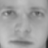

In [ ]:
a = cv.imread("1.BMP")
cv2_imshow(a)

In [ ]:
#import the library opencv
import cv2
#globbing utility.
import glob
#select the path
path = "https://github.com/jimgrasell/AMLR/blob/master/Project07/facesDB/S1/*.*"
for file in glob.glob(path):
  print(file)
  a= cv2.imread(file)
  print(a)
  # %%%%%%%%%%%%%%%%%%%%%
  #conversion numpy array into rgb image to show
  c = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  cv2.imshow('Color image', c)
  #wait for 1 second
  k = cv2.waitKey(1000)
  #destroy the window
  cv2.destroyAllWindows()


In [ ]:
from scipy import misc
ROWS = 48
COLS = 48
img= cv.imread('https://github.com/jimgrasell/AMLR/blob/master/Project07/facesDB/S1/1.BMP')
cv2_imshow(img)

AttributeError: ignored

In [ ]:
# Download the full MNIST dataset

def load_dataset():
  
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
 
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
 
	# one-hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
 
	return trainX, trainY, testX, testY



In [ ]:
#  Normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]

def prep_pixels(train, test):
  
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
 
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0

	# return normalized images
	return train_norm, test_norm



In [ ]:
# The CNN model has two main aspects: the feature extraction front end comprised of 
# convolutional and pooling layers, and the classifier backend that will make a prediction.


def create_compile_model_1():

  model = Sequential()
 
  # for the convolutional front-end, we can start with a single convolutional layer with 
  # a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. 
  # ============================================================================
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  # ============================================================================
 
  # The filter maps are flattened to provide features to the classifier.
  # ============================================================================
  model.add(Flatten())
  # ============================================================================
 
  # Between the feature extractor and the output layer, we can add a dense layer to interpret 
  # the features, in this case with 100 nodes. 
  # all layers will use the ReLU activation function and the He weight initialization scheme, 
  # which are best practices.
  # ============================================================================
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  # ============================================================================
 
  # Given that the problem is a multi-class classification task, we know that we will require an output 
  # layer with 10 nodes in order to predict the probability distribution of an image belonging to each 
  # of the 10 classes. This will also require the use of a softmax activation function. 
  # ============================================================================
  model.add(Dense(10, activation='softmax'))
  # ============================================================================
 
	# Use a conservative configuration for the stochastic gradient descent optimizer with a 
  # learning rate of 0.01 and a momentum of 0.9. 
  opt = SGD(lr=0.01, momentum=0.9)

  # The categorical cross-entropy loss function will be optimized, suitable for multi-class 
  # classification. Base class is Optimizer, but it could be SGD, Adam, RMSProp, etc.
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 
  return model


In [ ]:
# let's experiment with another  model

def create_compile_model_2():

  model = Sequential([
                                   
  # The first layer uses 64  filters (7 × 7) but no stride because 
  # images are not very large. It also sets input_shape=[28, 28, 1], because the
  # images are 28 × 28 pixels, with a single color channel (i.e., grayscale). 
  # A max pooling layer which uses a pool size of 2, so it divides each
  # spatial dimension by a factor of 2.
  # ============================================================================
  Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
  MaxPooling2D(2),
  # ============================================================================

  # For larger images repeat this same structure many times: convolutional 
  # layers followed by max pooling layers. Reduce size of feature maps in
  # subsequent layers.
  # the number of repetitions is a hyperparameter for tuning.
  # ============================================================================
  Conv2D(256, 3, activation="relu", padding="same"),
  Conv2D(256, 3, activation="relu", padding="same"),
  MaxPooling2D(2),

  Conv2D(128, 3, activation="relu", padding="same"),
  Conv2D(128, 3, activation="relu", padding="same"),
  MaxPooling2D(2),
  # ============================================================================

  # The-backend classifier is a fully-connected network, composed of two hidden 
  # dense layers and a dense output layer. Note that we must flatten its inputs, 
  # since a dense network expects a 1D array of features for each instance. We 
  # also add two dropout layers, each with a dropout rate of 50%, to reduce 
  # overfitting.
  # ============================================================================
  Flatten(),

  Dense(128, activation="relu"),
  Dropout(0.5),

  Dense(64, activation="relu"),
  Dropout(0.5),
  # ============================================================================

  # For multi-class classification of 10 digits
  # ============================================================================
  Dense(10, activation="softmax")
  # ============================================================================
  ])

  # The categorical cross-entropy loss function will be optimized, suitable for multi-class 
  # classification. Base class is Optimizer, but it could be SGD, adam, RMSProp, etc.
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model


In [ ]:
# Evaluate the model using k-fold cross-validation

def evaluate_model(model, dataX, dataY, n_folds):

	scores, histories = list(), list()
 
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
 
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
  
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
  
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('CV Fold accuracy:  %.3f' % (acc * 100.0))
  
		# stores scores
		scores.append(acc)
		histories.append(history)
  
	return scores, histories


In [ ]:
# Plot learning curves

def summarize_learning(histories):

  for i in range(len(histories)):
		
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		
    # plot accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='red', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='green', label='test')
  
    pyplot.show()

In [ ]:
# Summarize model performance

def summarize_performance(scores):

	# print summary
	print('Model Accuracy: mean=%.3f std=%.3f, folds=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
 


In [ ]:
# The main driver for evaluating the model

def process(model, num_folds):

	# load dataset
	trainX, trainY, testX, testY = load_dataset()
 
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
 
	# evaluate the model using CV
	scores, histories = evaluate_model(model, trainX, trainY, num_folds)
 
	# learning curves
	summarize_learning(histories)
 
	# summarize estimated performance
	summarize_performance(scores)

11493376/11490434 [==============================] - 0s 0us/step
CV Fold accuracy:  98.263
CV Fold accuracy:  99.440


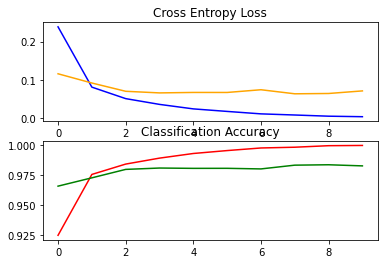

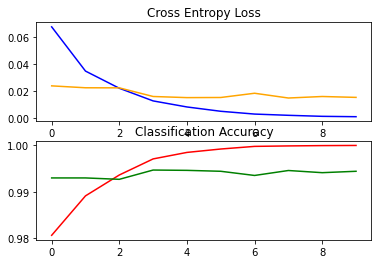

Model Accuracy: mean=98.852 std=0.588, folds=2


In [ ]:
from keras.models import save_model, load_model

# Experiment with two different CNN architectures

num_folds = 2

# model1 = load_model('model1.h5')
model1 = create_compile_model_1()

# evaluate the model
process(model1, num_folds)

# save the model
model1.save('model1.h5')


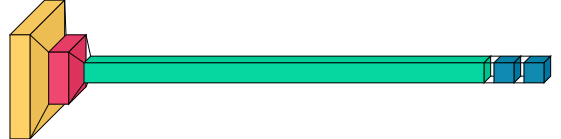

In [ ]:
#%pip install visualkeras
import visualkeras

# Draw model1's architecture

#visualkeras.layered_view(model1, to_file='output.png') # write to disk
#visualkeras.layered_view(model1, to_file='output.png').show() # write and show

visualkeras.layered_view(model1)


CV Fold accuracy:  98.897
CV Fold accuracy:  99.620


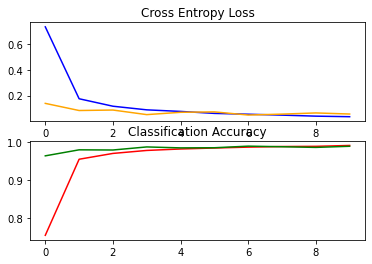

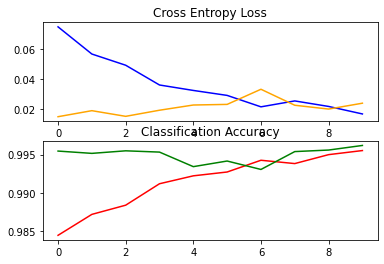

Model Accuracy: mean=99.258 std=0.362, folds=2


In [ ]:
# model2 = load_model('model2.h5')
model2 = create_compile_model_2()

# evaluate the model
process(model2, num_folds)

# save the model
model2.save('model2.h5')

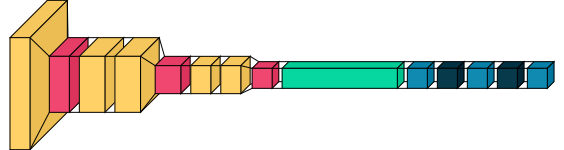

In [ ]:
#%pip install visualkeras
import visualkeras

# Draw model2's architecture

#visualkeras.layered_view(model2, to_file='output.png') # write to disk
#visualkeras.layered_view(model2, to_file='output.png').show() # write and show

visualkeras.layered_view(model2)
